# ON Model

In [1]:
import numpy as np
import pandas as pd

from pystatplottools.pdf_env.loading_figure_mode import loading_figure_mode
fma, plt = loading_figure_mode(develop=True) # develop=False will export the generated figures as pngs into "./data/RectangleData"
plt.style.use('seaborn-dark-palette')

if 'root_dir' not in locals():
    # Navigate to simulations/ONModel directory as simulation root directory
    import os
    os.chdir("../simulations/ONModel")
    root_dir = os.getcwd()

# To be able to compute custom measures
import sys
sys.path.append("./../../python_scripts")
    
mcmc_model_dir = "ONModelMetropolis/"
mcmc_data_dir = root_dir + "/data/" + mcmc_model_dir
mcmc_results_dir = root_dir + "/results/" + mcmc_model_dir

data_dir = root_dir + "/data/" + mcmc_model_dir
results_dir = root_dir + "/results/" + mcmc_model_dir

## MCMC Results

### Expectation Values

In [2]:
from mcmctools.modes.expectation_value import load_expectation_value_results
expectation_values = load_expectation_value_results(files_dir="ONModelMetropolis")
# Insert Kappa as column (as floating number)
expectation_values.insert(0, "Kappa", expectation_values.index.values.astype(np.float))
expectation_values = expectation_values.sort_values("Kappa")
expectation_values

Quantity   Kappa    ExpVal     Error    ExpVal                                \
Observable          Energy    Energy      Mean                                 
Element                                      0         1         2         3   
kappa                                                                          
-1.000000   -1.0 -3.318408  0.002549 -0.001410  0.000299  0.000641  0.000404   
-0.900000   -0.9 -2.339433  0.002578 -0.000814 -0.001655  0.000532  0.000881   
-0.800000   -0.8 -1.458381  0.002532  0.000463  0.000509 -0.000839 -0.000814   
-0.700000   -0.7 -0.643791  0.002790 -0.001060 -0.001243  0.001407 -0.000147   
-0.600000   -0.6  0.081969  0.002754  0.002185  0.000388 -0.000067  0.001522   
-0.500000   -0.5  0.697801  0.002162  0.001040 -0.000906  0.001463 -0.001624   
-0.400000   -0.4  1.066480  0.001919 -0.000603  0.000231  0.000868  0.000410   
-0.300000   -0.3  1.259083  0.001706 -0.000943  0.000117  0.000049 -0.000556   
-0.200000   -0.2  1.363664  0.001652  0.001804 -0.000758  0.000576 -0.001764   
-0.100000   -0.1  1.414970  0.001568  0.001405 -0.001310 -0.000144 -0.001254   
0.000000     0.0  1.434509  0.001629 -0.003621 -0.002231 -0.000386  0.000021   
0.100000     0.1  1.417451  0.001636  0.001628 -0.001616  0.004084 -0.001045   
0.200000     0.2  1.364707  0.001464 -0.003433 -0.004398  0.002139 -0.002368   
0.300000     0.3  1.259283  0.001695  0.003300  0.001246 -0.003613  0.005167   
0.400000     0.4  1.068400  0.001953 -0.003240 -0.010409 -0.001116  0.003595   
0.500000     0.5  0.684835  0.002160 -0.002094 -0.012204  0.018605 -0.011821   
0.600000     0.6  0.090292  0.002797  0.025114 -0.066610 -0.010135 -0.032186   
0.700000     0.7 -0.640265  0.002425 -0.001568 -0.031018  0.033861 -0.020685   
0.800000     0.8 -1.455872  0.002581  0.001714  0.050278  0.048424  0.081568   
0.900000     0.9 -2.342432  0.002326  0.119503 -0.107861 -0.009331 -0.155054   
1.000000     1.0 -3.315102  0.002460  0.064275  0.057090 -0.035635  0.201013   

Quantity       Error                                     ExpVal        Error  \
Observable      Mean                               SecondMoment SecondMoment   
Element            0         1         2         3                             
kappa                                                                          
-1.000000   0.000418  0.000459  0.000416  0.000401     2.444515     0.001256   
-0.900000   0.000471  0.000402  0.000441  0.000422     2.231775     0.001243   
-0.800000   0.000431  0.000460  0.000492  0.000435     2.023883     0.001231   
-0.700000   0.000485  0.000494  0.000474  0.000513     1.810626     0.001230   
-0.600000   0.000540  0.000522  0.000557  0.000564     1.604020     0.001280   
-0.500000   0.000598  0.000585  0.000602  0.000517     1.403125     0.001172   
-0.400000   0.000698  0.000584  0.000649  0.000613     1.273792     0.001027   
-0.300000   0.000697  0.000715  0.000769  0.000693     1.198900     0.000981   
-0.200000   0.000829  0.000764  0.000784  0.000831     1.160554     0.001017   
-0.100000   0.000867  0.000928  0.000871  0.000794     1.138380     0.000928   
0.000000    0.000911  0.000953  0.000892  0.000873     1.134381     0.000978   
0.100000    0.001063  0.001034  0.001069  0.001116     1.140756     0.000960   
0.200000    0.001100  0.001344  0.001175  0.001216     1.160086     0.000867   
0.300000    0.001459  0.001502  0.001595  0.001468     1.200025     0.001021   
0.400000    0.001790  0.001756  0.001755  0.002042     1.274784     0.001027   
0.500000    0.002549  0.002863  0.002544  0.002564     1.408890     0.001211   
0.600000    0.003233  0.003141  0.003326  0.003777     1.602495     0.001232   
0.700000    0.003805  0.003871  0.003761  0.003626     1.812787     0.001341   
0.800000    0.004197  0.004195  0.003957  0.004249     2.022768     0.001280   
0.900000    0.004676  0.004942  0.004811  0.004410     2.232611     0.001250   
1.000000    0.004726  0.005052  0.005109  0.005243     2.441844     0.001209   

In [3]:
# Computation of the two point correlator
total_mean = expectation_values.loc[:, ("ExpVal", "Mean", slice(None))].values.mean(axis=1)
two_point_correlator = expectation_values["ExpVal", "TwoPointCorrelation", ""].values - total_mean * total_mean

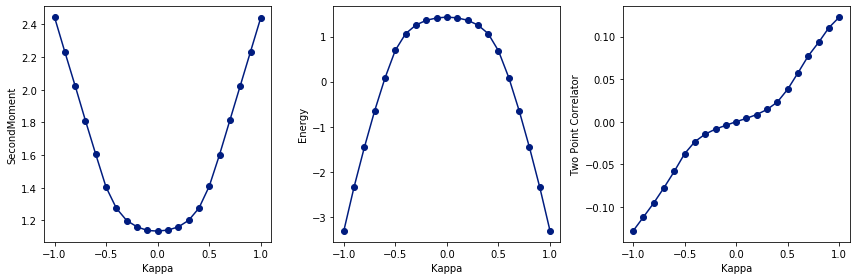

In [4]:
fig, axes = fma.newfig(1.4, ncols=3, figsize=(12, 4))

axes[0].plot(expectation_values["Kappa"], expectation_values["ExpVal", "SecondMoment", ""], "o-")
axes[0].set_xlabel("Kappa")
axes[0].set_ylabel("SecondMoment")

axes[1].plot(expectation_values["Kappa"], expectation_values["ExpVal", "Energy", ""], "o-")
axes[1].set_xlabel("Kappa")
axes[1].set_ylabel("Energy")

axes[2].plot(expectation_values["Kappa"], two_point_correlator, "o-")
axes[2].set_xlabel("Kappa")
axes[2].set_ylabel("Two Point Correlator")


plt.tight_layout()

fma.savefig(results_dir, "expectation_values")

## Configurations as Pytorch Dataset

We show how the mcmc configurations can be stored and loaded as a .pt file.

(See also python_scripts/loading_configurations.py and python_scripts/pytorch_data_generation.py)

### Preparation

In [5]:
data_generator_args = {
    # ConfigDataGenerator Args
    "data_type": "target_param",
    # Args for ConfigurationLoader
    "path": mcmc_data_dir,
    "total_number_of_data_per_file": 10000,
    "identifier": "expectation_value",
    "running_parameter": "kappa",
    "chunksize": 100  # If no chunksize is given, all data is loaded at once
}

# Prepare in memory dataset
from pystatplottools.pytorch_data_generation.data_generation.datagenerationroutines import prepare_in_memory_dataset
from mcmctools.pytorch.data_generation.datagenerationroutines import data_generator_factory

prepare_in_memory_dataset(
    root=data_dir,
    batch_size=89,
    data_generator_args=data_generator_args,
    data_generator_name="BatchConfigDataGenerator",
    data_generator_factory=data_generator_factory
)

Random seed is set by np.random.seed()


### Generating and Loading the Dataset

In [6]:
# Load in memory dataset
from pystatplottools.pytorch_data_generation.data_generation.datagenerationroutines import load_in_memory_dataset

# The dataset is generated and stored as a .pt file in the data_dir/data directory the first time this function is called. Otherwise the .pt is loaded.
data_loader = load_in_memory_dataset(
    root=data_dir, batch_size=128, data_generator_factory=data_generator_factory, slices=None, shuffle=True,
    num_workers=0, rebuild=False
    # sample_data_generator_name="ConfigDataGenerator"  # optional: for a generation of new samples
)

# Load training data
for batch_idx, batch in enumerate(data_loader):
    data, target = batch
    # print(batch_idx, len(data))

RDKit WARNING: [00:59:34] Enabling RDKit 2019.09.1b1 jupyter extensions


### Inspection of the Dataset - Sample Visualization

In [7]:
from pystatplottools.visualization import sample_visualization

config_dim = (8, 8)  # Dimension of the data
num_std=1

# Random samples
config, label = data_loader.dataset.get_random_sample()
batch, batch_label = data_loader.dataset.get_random_batch(108)

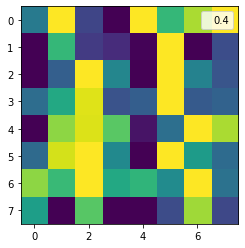

In [8]:
# Single Sample
sample_visualization.fd_im_single_sample(sample=config, label=label, config_dim=config_dim, num_std=num_std,
                                         fma=fma, filename="single_sample", directory=results_dir, figsize=(10, 4));

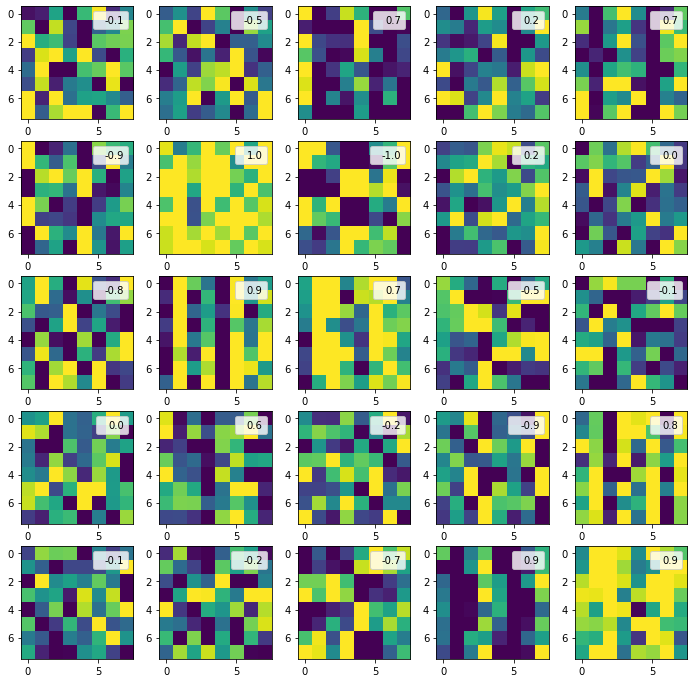

In [9]:
# Batch with labels
sample_visualization.fd_im_batch(batch, batch_labels=batch_label, num_samples=25, dim=(5, 5),
                                 config_dim=config_dim, num_std=num_std,
                                 fma=fma, filename="batch", directory=results_dir, width=2.3, ratio=1.0, figsize=(12, 12));

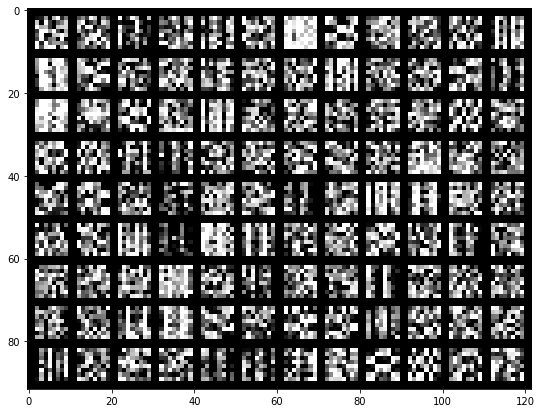

In [10]:
# Batch grid
sample_visualization.fd_im_batch_grid(batch, config_dim=config_dim, num_std=num_std,
                                      fma=fma, filename="batch_grid", directory=results_dir);